#NBA Salary Prediction 2017
###Solomon Kim



---


This problem focuses on predicting the salary of a given NBA player given their game statistics and twitter follows and retweets. 
>
The input into
the problem will be a myriad of statistics, such as, rebounds, points scored, 3-pointes made, and other traditional basketball statistics as well as the amount of wikipedia page views, twitter followers, and retweets. These two types of statistics are aimed to account for both social media and popularity, and in-game performance when predicting their salary. This is a regression problem in which we will use all features from the dataset excluding name of player and rank. I will evaluate the results based on MAE obtained from predicting salary on the test set. I really am looking for improvement from the baseline tests of linear regression and my neural network.




In [0]:
#Here we start by obtaining our data from Kaggle

!pip install kaggle

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
! ls -a /root/.kaggle

.  ..  kaggle.json


In [0]:
#Downloading our data
! kaggle datasets download -d noahgift/social-power-nba

social-power-nba.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
! unzip social-power-nba.zip

Archive:  social-power-nba.zip
replace nba_2016_2017_100.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2016_2017_100.csv   
replace nba_2017_att_val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2017_att_val.csv    
replace nba_2017_att_val_elo.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2017_att_val_elo.csv  
replace nba_2017_att_val_elo_with_cluster.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2017_att_val_elo_with_cluster.csv  
replace nba_2017_attendance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2017_attendance.csv  
replace nba_2017_br.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2017_br.csv         
replace nba_2017_elo.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2017_elo.csv        
replace nba_2017_endorsements.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nba_2017_endorsements.csv  
replace nba_2017_nba_players_with_salary.csv? [y]es, [n]o, [A]l

In [0]:
#Our function to upload files that will be re-used later on in the notebook
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [0]:
upload_files() #We need to upload our future_encoders.py file here to use later on while encoding our position data

Saving future_encoders.py to future_encoders (1).py


['future_encoders.py']

# Exploring The Data

In [0]:
import pandas as pd

def load_player_data():
    return pd.read_csv("nba_2017_players_with_salary_wiki_twitter.csv") #We are only using this data file because it combines all of the data that we need from the other data files.

In [0]:
player_data = load_player_data()

In [0]:
player_data.head()

,Unnamed: 0,Rk,PLAYER,POSITION,AGE,MP,FG,FGA,FG%,3P,...,DRPM,RPM,WINS_RPM,PIE,PACE,W,SALARY_MILLIONS,PAGEVIEWS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
0,0,1,Russell Westbrook,PG,28,34.6,10.2,24.0,0.425,2.5,...,-0.47,6.27,17.34,23.0,102.31,46,26.50,4279.0,2130.5,559.0
1,1,2,James Harden,PG,27,36.4,8.3,18.9,0.440,3.2,...,-1.57,4.81,15.54,19.0,102.98,54,26.50,3279.0,969.0,321.5
2,2,4,Anthony Davis,C,23,36.1,10.3,20.3,0.505,0.5,...,3.90,4.35,12.81,19.2,100.19,31,22.12,82.5,368.0,104.0
3,3,6,DeMarcus Cousins,C,26,34.2,9.0,19.9,0.452,1.8,...,0.64,4.20,11.26,17.8,97.11,30,16.96,1625.5,102.0,91.5
4,4,7,Damian Lillard,PG,26,35.9,8.8,19.8,0.444,2.9,...,-1.49,3.14,10.72,15.9,99.68,38,24.33,1830.5,186.5,43.0


In [0]:
player_data.shape #The data has 42 feautures, 40 of which we will use in our analysis. There unfortunately are not many samples, only 239, so we will have to use k-fold cross-validation to train our networks. 

(239, 42)

In [0]:
players_names = player_data["PLAYER"].unique()

In [0]:
name_dicts = {} 
keys = range(238)
values = players_names
for i in keys:
        name_dicts[i] = values[i]
print(name_dicts)

{0: 'Russell Westbrook', 1: 'James Harden', 2: 'Anthony Davis', 3: 'DeMarcus Cousins', 4: 'Damian Lillard', 5: 'LeBron James', 6: 'Kawhi Leonard', 7: 'Stephen Curry', 8: 'Kyrie Irving', 9: 'Kevin Durant', 10: 'Karl-Anthony Towns', 11: 'Jimmy Butler', 12: 'Paul George', 13: 'Andrew Wiggins', 14: 'Kemba Walker', 15: 'Bradley Beal', 16: 'John Wall', 17: 'Carmelo Anthony', 18: 'Klay Thompson', 19: 'Devin Booker', 20: 'Gordon Hayward', 21: 'Blake Griffin', 22: 'Eric Bledsoe', 23: 'Mike Conley', 24: 'Goran Dragic', 25: 'Joel Embiid', 26: 'Jabari Parker', 27: 'Marc Gasol', 28: 'Kevin Love', 29: 'Zach LaVine', 30: 'Dwyane Wade', 31: 'Danilo Gallinari', 32: 'Paul Millsap', 33: 'Chris Paul', 34: 'Kristaps Porzingis', 35: 'Derrick Rose', 36: 'Dennis Schroder', 37: 'LaMarcus Aldridge', 38: 'Evan Fournier', 39: 'George Hill', 40: 'Nikola Jokic', 41: 'Eric Gordon', 42: 'Tobias Harris', 43: 'Victor Oladipo', 44: 'Dion Waiters', 45: 'Wilson Chandler', 46: "D'Angelo Russell", 47: 'Jrue Holiday', 48: 'J

In [0]:
sample_incomplete_rows = player_data[player_data.isnull().any(axis=1)].head() #We only have 5 rows of data that we will remove when splitting our data
sample_incomplete_rows

,Unnamed: 0,Rk,PLAYER,POSITION,AGE,MP,FG,FGA,FG%,3P,...,DRPM,RPM,WINS_RPM,PIE,PACE,W,SALARY_MILLIONS,PAGEVIEWS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
128,128,193,Tyson Chandler,C,34,27.6,3.3,4.9,0.671,0.0,...,2.20,1.14,3.55,13.1,101.88,15,12.42,832.0,29.0,9.0
146,146,225,David Lee,PF,33,18.7,3.1,5.3,0.590,0.0,...,1.50,1.12,3.98,12.6,98.36,58,1.55,42.0,56.5,35.0
175,175,301,Ian Mahinmi,C,30,17.9,2.1,3.6,0.586,0.0,...,3.11,0.89,1.44,8.2,98.90,19,15.94,162.5,10.0,5.0
204,204,373,Anthony Brown,SF,24,14.5,1.6,4.5,0.360,0.6,...,-0.34,-1.76,0.08,5.8,94.67,3,0.06,11.0,3.0,3.0
213,213,386,Dragan Bender,PF,19,13.3,1.3,3.7,0.354,0.7,...,-0.68,-3.88,-0.28,3.3,100.06,13,4.28,495.0,NaN,NaN


In [0]:
player_data.dtypes #Here we check to see if there are any data types that are objects to encode

Unnamed: 0                  int64
Rk                          int64
PLAYER                     object
POSITION                   object
AGE                         int64
MP                        float64
FG                        float64
FGA                       float64
FG%                       float64
3P                        float64
3PA                       float64
3P%                       float64
2P                        float64
2PA                       float64
2P%                       float64
eFG%                      float64
FT                        float64
FTA                       float64
FT%                       float64
ORB                       float64
DRB                       float64
TRB                       float64
AST                       float64
STL                       float64
BLK                       float64
TOV                       float64
PF                        float64
POINTS                    float64
TEAM                       object
GP            

From this initial look at the correlation matrix it seems af if points are the most important determinant of salary

In [0]:
corr_matrix = player_data.corr()
corr_matrix['SALARY_MILLIONS'].sort_values(ascending=False)

SALARY_MILLIONS           1.000000
POINTS                    0.643019
FG                        0.630978
FT                        0.623383
FTA                       0.621370
FGA                       0.615622
2PA                       0.598910
2P                        0.598556
WINS_RPM                  0.579560
MP                        0.577275
MPG                       0.577243
PIE                       0.577111
TOV                       0.538096
ORPM                      0.533787
DRB                       0.533587
RPM                       0.517810
AST                       0.503913
TRB                       0.472329
STL                       0.453844
PAGEVIEWS                 0.420632
3P                        0.358943
AGE                       0.354779
W                         0.353315
3PA                       0.351533
GP                        0.296519
PF                        0.257797
FT%                       0.246079
TWITTER_RETWEET_COUNT     0.240484
TWITTER_FAVORITE_COU

 Looking at these scatter plots we can see that points are strongly correlated with salary, as well as many other feautres. It looks as if we cannot eliminate any features when training our models.

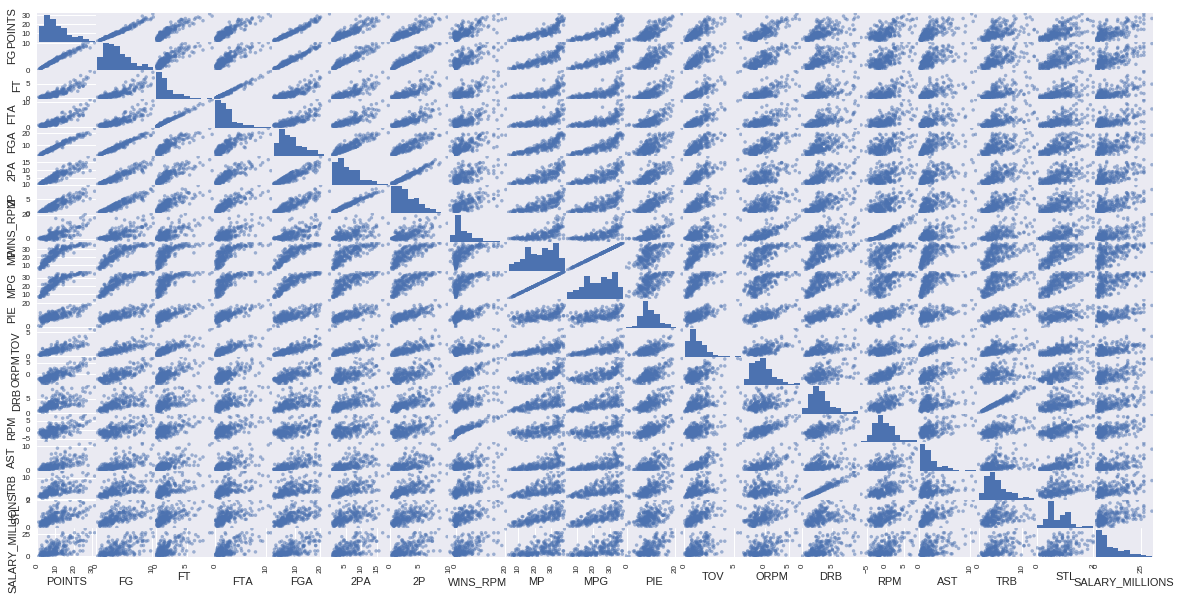

In [0]:
from pandas.plotting import scatter_matrix

attributes = ["POINTS", "FG", "FT", "FTA", "FGA", "2PA", "2P", "WINS_RPM", "MP", "MPG", "PIE", "TOV", "ORPM", "DRB", "RPM", "AST", "TRB", "STL", "SALARY_MILLIONS"]

plot = scatter_matrix(player_data[attributes], figsize=(20, 10))

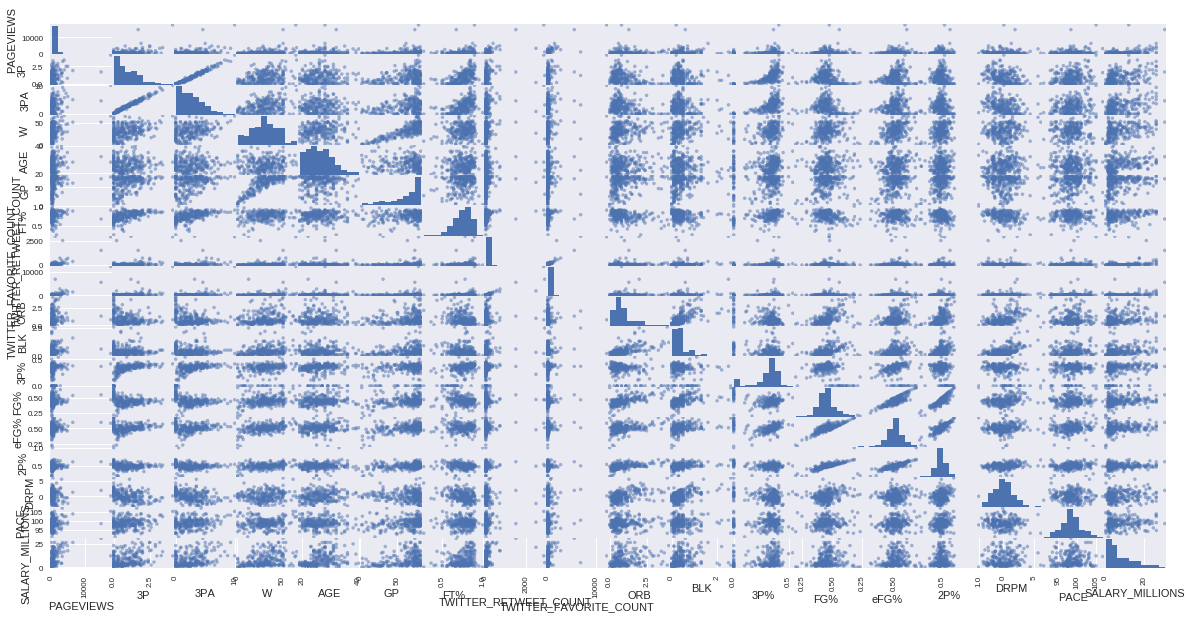

In [0]:
from pandas.plotting import scatter_matrix

attributes = ["PAGEVIEWS", "3P", "3PA", "W", "AGE", "GP", "FT%", "TWITTER_RETWEET_COUNT"
         , "TWITTER_FAVORITE_COUNT", "ORB", "BLK", "3P%", "FG%", "eFG%", "2P%", "DRPM", "PACE", "SALARY_MILLIONS"]

plot = scatter_matrix(player_data[attributes], figsize=(20, 10))

##Findings

We clearly need to use all features in the data other than the rank, player name, and unnamed categories. Our data seems to be nicely correlated to salary, and shouldn't be a problem to train. We will send 42 features into our pipeline and take out the un-needed ones. We will then encode our positions and merge the data in a feature union to get ready for training.


In [0]:
#Here we will be splitting the data into a train and test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(player_data.dropna(), test_size=0.2, random_state=42)

train_set_target = train_set["SALARY_MILLIONS"].copy() #We are saving the salary data to these two variables so we can have validation data later
test_set_target = test_set["SALARY_MILLIONS"].copy()

In [0]:
player_data.shape

(239, 42)

In [0]:
test_set.shape

(46, 42)

In [0]:
train_set_target.shape

(182,)

In [0]:
train_set.shape

(182, 42)

In [0]:
from sklearn.pipeline import Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from future_encoders import OneHotEncoder

class ColumnSelector(BaseEstimator, TransformerMixin): #This is a column selector function that I wrote to select which features I want to keep in my data when running it through the pipeline
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
       assert isinstance(X, pd.DataFrame)

       try:
            return X[self.columns]
       except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame doesn't include the columns: %s" % cols_error)
            
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
    
cat_attribs = ["POSITION"] #We are selecting only our position data to be encoded.

cols = ["FG", "POINTS", "FT", "FTA", "FGA", "2PA", "2P", "WINS_RPM", "MP", "MPG", "PIE", "TOV", "ORPM", "DRB", "RPM", "AST", "TRB", "STL", "PAGEVIEWS", "3P", "3PA", "W", "AGE", "GP", "FT%", "TWITTER_RETWEET_COUNT",
         "TWITTER_FAVORITE_COUNT", "ORB", "BLK", "3P%", "FG%", "eFG%", "2P%", "DRPM", "PACE"]   

pipeline = Pipeline([
    ('column_selector', ColumnSelector(columns =  cols))
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

from sklearn.pipeline import FeatureUnion 

full_pipeline = FeatureUnion(transformer_list=[
    ('pipeline', pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [0]:
prepared_train_set = full_pipeline.fit_transform(train_set)
prepared_test_set = full_pipeline.fit_transform(test_set)

In [0]:
prepared_train_set.shape

(182, 40)

In [0]:
prepared_test_set.shape

(46, 40)

In [0]:
prepared_test_set[:5]


array([[ 1.1000e+00,  2.9000e+00,  5.0000e-01,  6.0000e-01,  3.0000e+00,
         2.2000e+00,  8.0000e-01,  2.8000e-01,  7.9000e+00,  7.9000e+00,
         7.8000e+00,  4.0000e-01, -2.4400e+00,  1.0000e+00, -1.6100e+00,
         9.0000e-01,  1.1000e+00,  4.0000e-01,  1.1650e+02,  3.0000e-01,
         8.0000e-01,  2.5000e+01,  2.2000e+01,  3.7000e+01,  8.1800e-01,
         1.7500e+01,  0.0000e+00,  1.0000e-01,  1.0000e-01,  3.7900e-01,
         3.5100e-01,  4.0100e-01,  3.4100e-01,  8.3000e-01,  9.7630e+01,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 4.9000e+00,  1.3700e+01,  2.7000e+00,  3.5000e+00,  1.1300e+01,
         7.9000e+00,  3.6000e+00,  4.7200e+00,  2.9800e+01,  2.9800e+01,
         1.0800e+01,  1.2000e+00,  1.3000e-01,  3.3000e+00,  3.1000e-01,
         3.2000e+00,  4.0000e+00,  1.2000e+00,  1.1000e+01,  1.3000e+00,
         3.4000e+00,  3.5000e+01,  2.4000e+01,  7.3000e+01,  7.6800e-01,
         6.0000e+00,  3.0000e+00,  7.0000e-01,  6.

##Baseline

### Training

I decided to use a classic LinearRegression function as my baseline measurement. I then evaluated random forest, linear regression, and decision trees to determine which was the best baseline method to use. After finding which was the best I tuned the baseline's hyperparameters. The best baseline method was a random forest regressor using 35 features and 30 parameters. 

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(prepared_train_set, train_set_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [0]:
player_predictions = lin_reg.predict(prepared_train_set)

from sklearn.metrics import mean_squared_error
import numpy as np

# compute RMSE for training set (training error)
lin_mse = mean_squared_error(train_set_target, player_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.8617531073867974

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(prepared_train_set, train_set_target)

player_predictions = tree_reg.predict(prepared_train_set)

tree_mse = mean_squared_error(train_set_target, player_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

#As expected the error is very low due to overfitting

0.003668996928526717

In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(prepared_train_set, train_set_target)

player_predictions = forest_reg.predict(prepared_train_set)

forest_mse = mean_squared_error(train_set_target, player_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2.0673747779188094

Using a 10-Fold Cross-Validation we can see that all methods have significant amounts of error with the random forest performing the best

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, prepared_train_set, train_set_target,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [4.97281928 6.82494033 4.33851165 4.9912401  4.03385534 7.86494861
 3.65238202 6.09111375 8.46328541 7.17217192]
Mean: 5.840526841369636
Standard deviation: 1.5988928055204084


In [0]:
lin_scores = cross_val_score(lin_reg, prepared_train_set, train_set_target,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [5.91104835 4.96446877 4.08052121 4.29884182 3.92743853 6.57351741
 6.69358449 5.90452673 4.89449923 3.98473602]
Mean: 5.12331825636623
Standard deviation: 1.0183759244150083


In [0]:
forest_scores = cross_val_score(forest_reg, prepared_train_set, train_set_target,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [5.27346415 3.80782201 4.50816142 4.83455187 4.42163419 5.36703667
 4.87273517 6.59311147 5.57742217 3.887881  ]
Mean: 4.914382012270322
Standard deviation: 0.7928236447282848


In [0]:
#Seeing as the random forest regressor returned the least amount of error we use that for tuning
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 5, 10, 20, 30], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [0]:
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(prepared_train_set, train_set_target)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 5, 10, 20, 30], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
grid_search.best_params_

#These will be used for our final evaluation

{'max_features': 35, 'n_estimators': 30}

In [0]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=35, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [0]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5.718049496886159 {'max_features': 2, 'n_estimators': 3}
5.730224921270687 {'max_features': 2, 'n_estimators': 5}
5.326807287847772 {'max_features': 2, 'n_estimators': 10}
5.1193883789835475 {'max_features': 2, 'n_estimators': 20}
5.0668862064461315 {'max_features': 2, 'n_estimators': 30}
5.946893074994812 {'max_features': 4, 'n_estimators': 3}
5.6667469956642105 {'max_features': 4, 'n_estimators': 5}
5.367651419441739 {'max_features': 4, 'n_estimators': 10}
5.046470224284136 {'max_features': 4, 'n_estimators': 20}
5.115794230811076 {'max_features': 4, 'n_estimators': 30}
5.61666525363837 {'max_features': 6, 'n_estimators': 3}
5.39946878746541 {'max_features': 6, 'n_estimators': 5}
5.042257490885963 {'max_features': 6, 'n_estimators': 10}
4.931318793365312 {'max_features': 6, 'n_estimators': 20}
5.015316714869061 {'max_features': 6, 'n_estimators': 30}
5.992633652069188 {'max_features': 8, 'n_estimators': 3}
5.491009032604265 {'max_features': 8, 'n_estimators': 5}
5.3031237568220995 {'

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([4.29371868e-03, 2.49374964e-02, 2.92186346e-01, 6.08509243e-02,
       2.30666401e-02, 2.17268168e-02, 1.64790684e-02, 3.36529401e-03,
       4.01933652e-02, 2.03083627e-02, 4.93762384e-02, 8.42809979e-03,
       1.88861744e-02, 2.58107655e-02, 7.37566847e-03, 1.13956596e-02,
       1.51567312e-02, 5.04722522e-03, 5.56980447e-02, 4.30292424e-03,
       6.88912428e-03, 8.35328492e-03, 1.15606665e-01, 2.77207443e-02,
       1.22811501e-02, 1.64131196e-02, 1.09254650e-02, 7.85169887e-03,
       5.51553475e-03, 1.29959819e-02, 5.48409173e-03, 1.30603002e-02,
       8.88234886e-03, 1.17432207e-02, 2.14408807e-02, 2.27401438e-03,
       1.08223056e-03, 6.25827517e-04, 1.93278413e-03, 3.59676901e-05])

Interestingly, points still seem to be the most important feature as predicted from our scatter-plots. Wins are the second most, but points dominates over all other features

In [0]:
attributes = cat_attribs + x_cols
sorted(zip(feature_importances, attributes), reverse=True)

[(0.29218634637588986, 'POINTS'),
 (0.11560666545760659, 'W'),
 (0.06085092430089794, 'FT'),
 (0.05569804465630613, 'STL'),
 (0.0493762383949163, 'MPG'),
 (0.040193365209314776, 'WINS_RPM'),
 (0.027720744250871662, 'AGE'),
 (0.02581076550655839, 'ORPM'),
 (0.024937496386802684, 'FG'),
 (0.023066640063472026, 'FTA'),
 (0.02172681683796583, 'FGA'),
 (0.021440880673825928, 'DRPM'),
 (0.020308362704774492, 'MP'),
 (0.018886174372287404, 'TOV'),
 (0.016479068366700947, '2PA'),
 (0.016413119598547153, 'FT%'),
 (0.01515673119714943, 'AST'),
 (0.013060300227415741, 'FG%'),
 (0.012995981868645501, 'BLK'),
 (0.012281150136568199, 'GP'),
 (0.011743220701991032, '2P%'),
 (0.011395659598059998, 'RPM'),
 (0.01092546501825736, 'TWITTER_RETWEET_COUNT'),
 (0.008882348856933567, 'eFG%'),
 (0.008428099793304448, 'PIE'),
 (0.0083532849216963, '3PA'),
 (0.007851698869916712, 'TWITTER_FAVORITE_COUNT'),
 (0.007375668468859716, 'DRB'),
 (0.0068891242836515406, '3P'),
 (0.005515534746900272, 'ORB'),
 (0.005484

###Testing

In [0]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(prepared_test_set)
final_mse = mean_squared_error(test_set_target, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

4.339486267231372

In [0]:
lin_reg = LinearRegression()

# train the model on entire training set
lin_reg.fit(prepared_train_set, train_set_target)

# predict values for test set
lin_reg_predictions = lin_reg.predict(prepared_test_set)
lin_reg_mse = mean_squared_error(test_set_target, lin_reg_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)

print(lin_reg_rmse)

4.66990161825421


We did perform a little bit better after fine-tuning our model. While the improvement wasn't anything monumental it did do better than classic linear regression and better than the baseline random forest regression that we initially trained

## Neural Network

###Training

To find out which neural network parameters were best I repeated the process of training with k-fold cross-validation, because of our small dataset, and then plotting the error values over 1000 or so epochs to find how many epochs should be chosen. I tuned for batch size, number of hidden units, and number of dense layers. The process was repeated many times finally yielding a network of 16 hidden units, with 5 dense layers, and a batch size of 128, ran over 200 epochs. 
>
>

A note for how the testing was done for batch size. I tested for all batch sizes with all other parameters constants to isolate how many batches would be best. 

In [0]:
upload_files() #Here you should import all images in "Neural Analysis" folder

[]

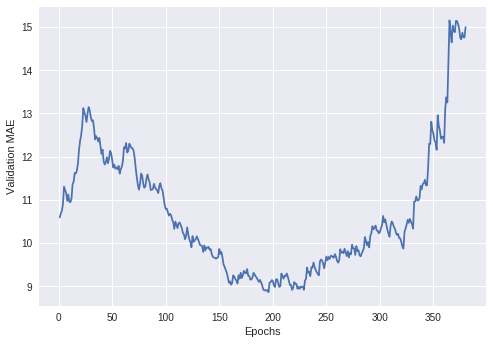

In [0]:
from IPython.display import Image, display
display(Image('8 batch_size.png'))

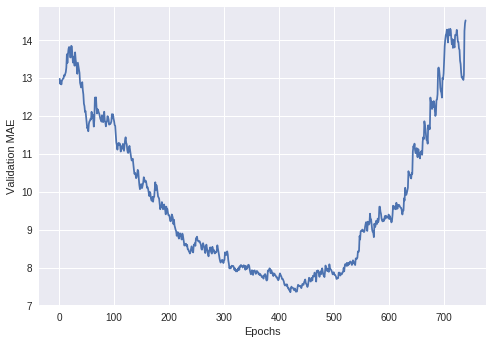

In [0]:
display(Image('16 batch_size.png'))

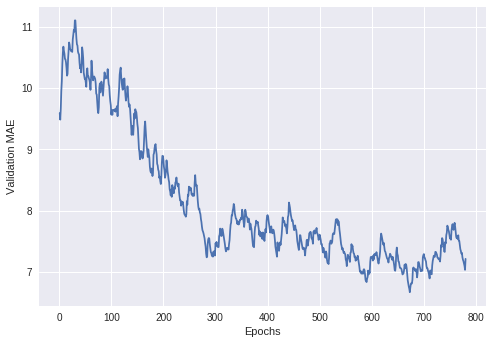

In [0]:
display(Image('64 batch_size.png'))

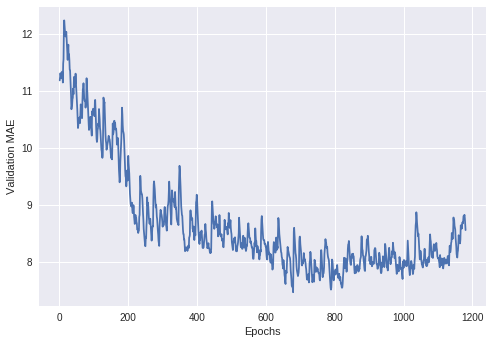

In [0]:
display(Image('128 batch_size.png'))

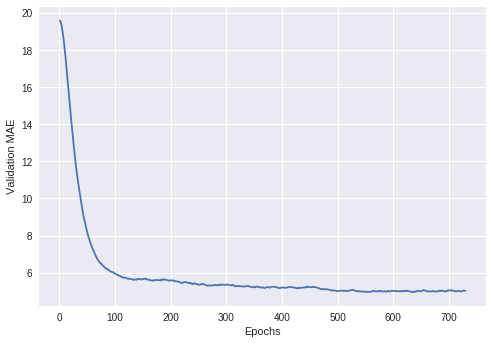

In [0]:
display(Image('8_units_2_layers.png'))

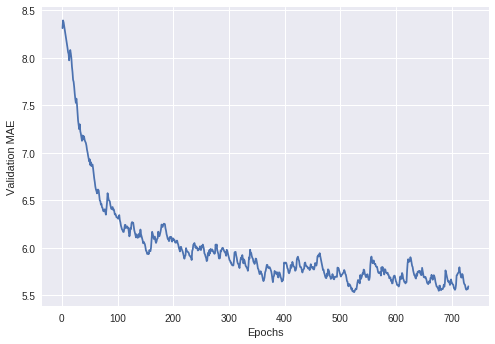

In [0]:
display(Image('16_units_2_layers.png'))

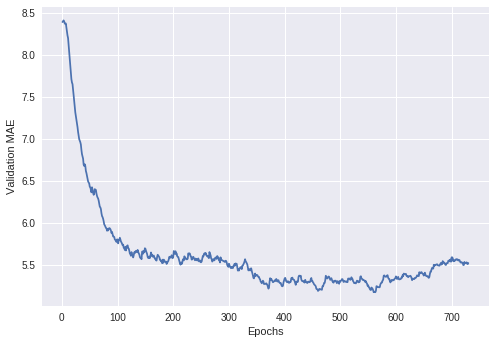

In [0]:
display(Image('16_units_3_layers.png'))

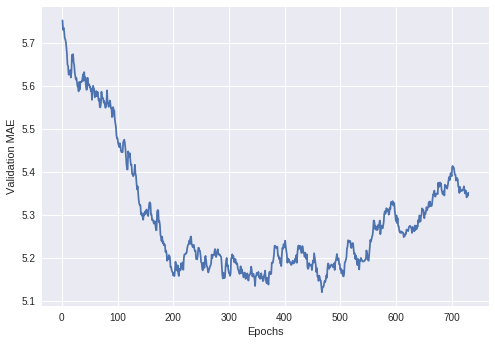

In [0]:
display(Image('16_units_5_layers.png'))

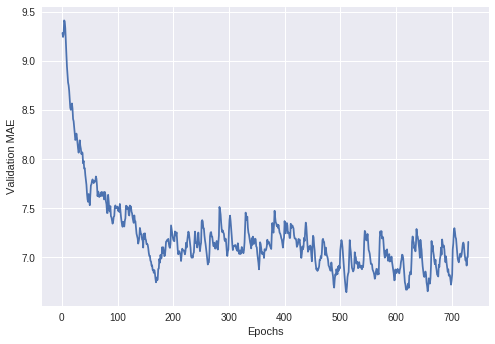

In [0]:
display(Image('32_units.png'))

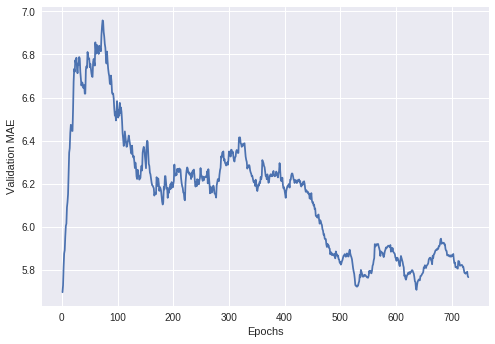

In [0]:
display(Image('32_units_3_layers.png'))

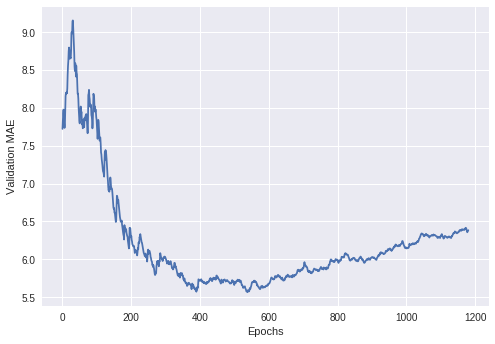

In [0]:
display(Image('64_units_2_dense.png'))

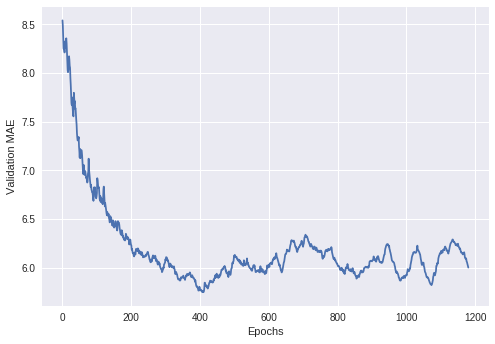

In [0]:
display(Image('64_units_3_dense.png'))

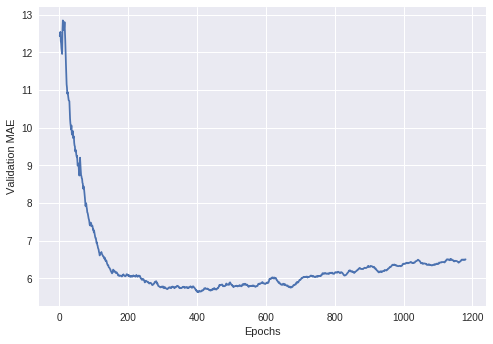

In [0]:
display(Image('128_units_2_dense.png'))

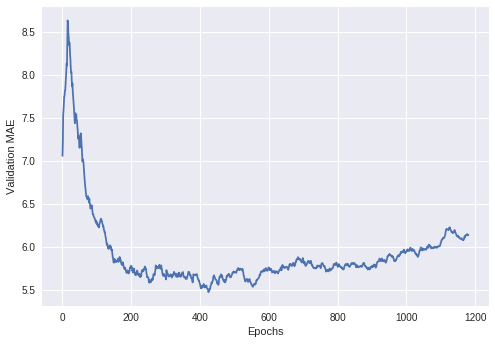

In [0]:
display(Image('128_units_3_dense.png'))

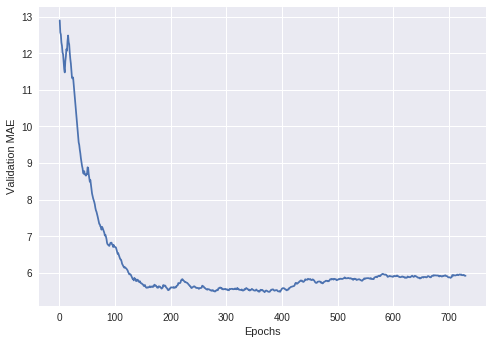

In [0]:
display(Image('512_units_3.1_layers.png'))

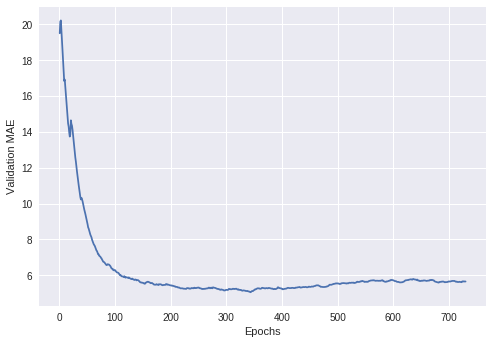

In [0]:
display(Image('512_units_3_dense.png'))

In [0]:
import keras
keras.__version__

import tensorflow as tf
from keras import models
from keras import layers

  
def build_model1():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
  
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(prepared_train_set.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1)) #no other constraint because we want it to be linear
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    
    return model

In [0]:
k = 10 #Using 10-fold cross-validation due to the lack of data

num_val_samples = len(prepared_train_set) // k
num_epochs = 750
num_batch = 128
all_mae_histories = []


for i in range(k):
    print('processing fold #', i)
    
    # Preparing validation data
    val_data = prepared_train_set[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_set_target[i * num_val_samples: (i + 1) * num_val_samples]

    # Preparing training data
    partial_train_data = np.concatenate(
        [prepared_train_set[:i * num_val_samples],
         prepared_train_set[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_set_target[:i * num_val_samples],
         train_set_target[(i + 1) * num_val_samples:]],
        axis=0)

    # Building model
    model = build_model1()
    # Train the model
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=num_batch, verbose=0)

    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


In [0]:
np.mean(all_mae_histories)

5.34092364136378

In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

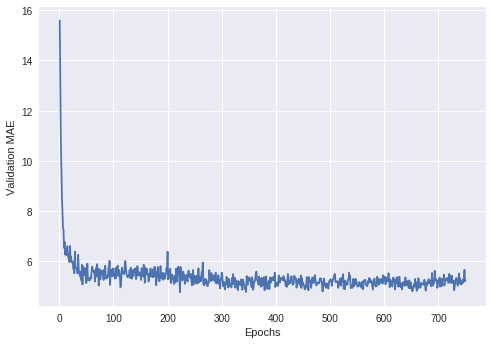

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

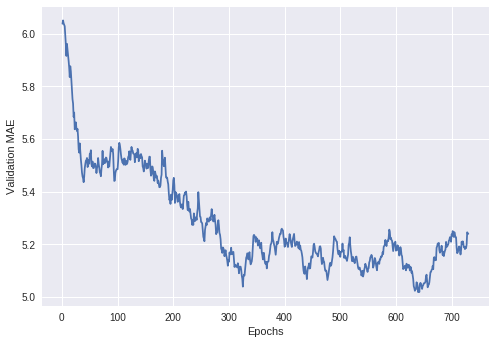

In [0]:
#Smoothing our curve to be able to see exactly where we are overfitting
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[20:1200])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It seems like past 400 epochs we are overfitting, so we will use 400 epochs on our final evaluations

### Test

In [0]:
# Get a fresh, compiled model.
model = build_model1()
# Train it on the entirety of the data.
model.fit(prepared_train_set, train_set_target,
          epochs=400, batch_size=128, verbose=0)
train_mse_score, train_mae_score = model.evaluate(prepared_train_set, train_set_target)

182/182 [==============================] - 2s 10ms/step


In [0]:
train_mae_score

3.431615229491349

In [0]:
model = build_model1()
# Train it on the entirety of the data.
model.fit(prepared_train_set, train_set_target,
          epochs=400, batch_size=128, verbose=0)
test_mse_score, test_mae_score = model.evaluate(prepared_test_set, test_set_target)

46/46 [==============================] - 2s 40ms/step


In [0]:
test_mae_score

3.465036983075349

# Evaluations

Our trained neural net returned a score of 3.465 and our baseline random forest regressor returned a score of 4.339. Our neural net did perform better than the random forest regressor and is, in my opinion, the clear winner. One major limitation is that we do not have enough data to truly see how effective our neural net can be. While I do not think that we are experiencing overfitting, I do believe that we need more data to keep up with the amount of features that are present in our data set. While we were only given data for 2017 I think that we can determine that our neural network better predicted the salary of an NBA player given their on-court and some off-court statistics. 

>

Another note is that our results for the neural network may vary based on attempt due to the limited amount of data the splits are highly volatile. 